Ансамблевые методы: частный случай Bagging - метод случайного леса (Random Forest). Для выполнения задания возьмите датасет о заболевании сахарным диабетом.

In [ ]:
import pandas as pd

df = pd.read_csv("diabetes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:

df.drop("Insulin", inplace=True, axis=1)
df.drop("SkinThickness", inplace=True, axis=1)
df[df == 0].count()

,0
Pregnancies,111
Glucose,5
BloodPressure,35
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [ ]:
# убрать строки с отрицательными и нулевыми значениями.
cols_to_check= [col for col in df.columns if col not in ['Pregnancies',
                                                         'DiabetesPedigreeFunction',
                                                         'Outcome']]
any_zero_indexer= (df[cols_to_check] <= 0).any(axis='columns')
df1 = df.loc[~any_zero_indexer]

print("осталось записей:", len(df1))

осталось записей: 724


In [ ]:
# разделить.
from sklearn.model_selection import train_test_split


df1_y = df1['Outcome']
df1_x = df1.loc[:, df1.columns != "Outcome"]

df2x_train, df2x_test, df2y_train, df2y_test = train_test_split(df1_x, df1_y,
                                                                test_size=0.3)
print("количество для тренировки:", len(df2x_train))
print("количество для проверки:", len(df2y_test))

количество для тренировки: 506
количество для проверки: 218


В качестве базового метода используется метод решающих деревьев. Обязательно дайте описание гиперпараметров построенной модели. Позволило ли существенно улучшить качество прогноза заболевания такое усовершенствование алгоритма?

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


model =  RandomForestClassifier()
# n_estimators - количество деревьев в лесу = 100
# max_features - Число признаков для выбора расщепления = 'sqrt'
# min_samples_split - Минимальное число объектов, при котором выполняется расщепление = 2
# min_samples_leaf - Ограничение на число объектов в листьях = 1
# max_depth - Максимальная глубина деревьев = None
# criterion - Критерий расщепления = 'gini'

model.fit(df2x_train, df2y_train)
df2y_pred = model.predict(df2x_test)

print ("AUC-ROC (test) = ", roc_auc_score(df2y_test, df2y_pred))
print(classification_report(df2y_test, df2y_pred))

AUC-ROC (test) =  0.6395752895752896
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       148
           1       0.59      0.41      0.49        70

    accuracy                           0.72       218
   macro avg       0.67      0.64      0.65       218
weighted avg       0.70      0.72      0.70       218



С параметрами по умолчанию случайный лес хуже оптимального решающего дерева по recall.

Определите оптимальное количество базовых алгоритмов в ансамбле (постройте график зависимости точности определения класса от количества деревьев).

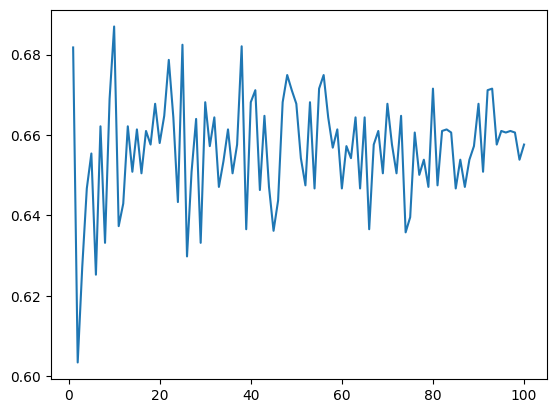

In [ ]:
import matplotlib.pyplot as plt


n_est = list(range(1, 101))
ras = []
for n in n_est:
    model =  RandomForestClassifier(n_estimators = n)

    model.fit(df2x_train, df2y_train)
    df2y_pred = model.predict(df2x_test)
    ras.append(roc_auc_score(df2y_test, df2y_pred))

plt.plot(n_est, ras)

In [ ]:
import numpy as np


print("лучшее количество деревьев:", np.argmax(ras)+1)

лучшее количество деревьев: 10


Определите оптимальную глубину деревьев, постройте график.

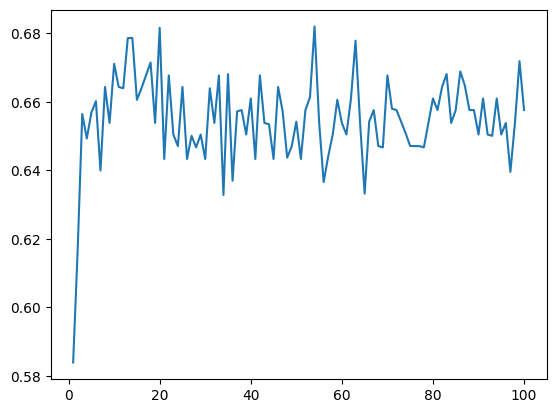

In [ ]:
max_depth = list(range(1, 101))
ras = []
for md in max_depth:
    model =  RandomForestClassifier(51,
                                    max_depth = md)

    model.fit(df2x_train, df2y_train)
    df2y_pred = model.predict(df2x_test)
    ras.append(roc_auc_score(df2y_test, df2y_pred))

plt.plot(n_est, ras)

In [ ]:
print("лучшая максимальная глубина деревьев:", np.argmax(ras)+1)

лучшая максимальная глубина деревьев: 54


In [ ]:
model =  RandomForestClassifier(n_estimators = 20, max_depth = 10)

model.fit(df2x_train, df2y_train)
df2y_pred = model.predict(df2x_test)

print ("AUC-ROC (test) = ", roc_auc_score(df2y_test, df2y_pred))
print(classification_report(df2y_test, df2y_pred))

AUC-ROC (test) =  0.682046332046332
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       148
           1       0.65      0.49      0.56        70

    accuracy                           0.75       218
   macro avg       0.72      0.68      0.69       218
weighted avg       0.74      0.75      0.74       218



с оптимальными параметрами recall все еще ниже чем у решающего дерева.

Попробуйте уровнять количество наблюдений по классам (RandomUnderSampler, RandomOverSampler, см. прилагаемый материал).

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


df3x, df3y = RandomUnderSampler().fit_resample(df1_x, df1_y)
df3x_train, df3x_test, df3y_train, df3y_test = train_test_split(df3x, df3y,
                                                                test_size=0.3)
print("количество для тренировки:", len(df3x_train))
print("количество для проверки:", len(df3y_test))

model.fit(df3x_train, df3y_train)

df3y_pred = model.predict(df3x_test)
print(classification_report(df3y_test, df3y_pred)) # отчет на урезанных данных.

df1y_pred = model.predict(df1_x)
print(classification_report(df1_y, df1y_pred)) # отчет на исходных данных.

количество для тренировки: 348
количество для проверки: 150
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        78
           1       0.75      0.78      0.76        72

    accuracy                           0.77       150
   macro avg       0.77      0.77      0.77       150
weighted avg       0.77      0.77      0.77       150

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       475
           1       0.76      0.94      0.84       249

    accuracy                           0.88       724
   macro avg       0.86      0.89      0.87       724
weighted avg       0.89      0.88      0.88       724



при балансе классов вниз тест дает 78 ~ 93 % полноты обнаружения болезни, что лучше решающего дерева.

In [ ]:
from imblearn.over_sampling import RandomOverSampler


df4x, df4y = RandomOverSampler().fit_resample(df1_x, df1_y)
df4x_train, df4x_test, df4y_train, df4y_test = train_test_split(df4x, df4y,
                                                                test_size=0.3)
print("количество для тренировки:", len(df4x_train))
print("количество для проверки:", len(df4y_test))

model.fit(df4x_train, df4y_train)

df4y_pred = model.predict(df4x_test)
print(classification_report(df4y_test, df4y_pred)) # отчет на увеличенных данных.

df1y_pred = model.predict(df1_x)
print(classification_report(df1_y, df1y_pred)) # отчет на исходных данных.

количество для тренировки: 665
количество для проверки: 285
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       146
           1       0.83      0.88      0.85       139

    accuracy                           0.85       285
   macro avg       0.85      0.85      0.85       285
weighted avg       0.85      0.85      0.85       285

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       475
           1       0.90      0.94      0.92       249

    accuracy                           0.94       724
   macro avg       0.93      0.94      0.94       724
weighted avg       0.94      0.94      0.94       724



при балансе классов вверх тест дает 85 ~ 92 % полноты обнаружения болезни, что лучше решающего дерева.